# Amazing ML journey with Stan    
Welcome! Let me show you around on this amazing experience.   
FOR THE LOVE OF GOD DO NOT JUST RUN THE WHOLE THING!    


## 1. Data processing

#### The path    
First, make sure that you have created a .py file containing variable AUDIO_DATA_PATH with the path to the audio data, pointing to AUDIO.

In [2]:
import paths
# Create a .py file containing variable AUDIO_DATA_PATH with the path to the audio data, pointing to AUDIO
AUDIO_DATA_PATH = paths.AUDIO_DATA_PATH
# The structure of the data folder should be as follows:

#         ↓   The path should be pointing to this folder
# data/AUDIO/
#           FAKE
#           REAL

### Imports

In [3]:
# Imports go brrrrrr
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import wave
import cv2
import matplotlib.pyplot as plt
import sklearn
import scipy.io.wavfile as wav

from keras import layers
from keras import models
from IPython import display
from pydub import AudioSegment

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split


c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### Splitting audio    


In [4]:
# Splitting the data into 10 second fragments and saving them to the AUDIO folder

def split_audio(input_folder, output_folder, duration=10):

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith(".mp3") or file.endswith(".wav"):
                input_path = os.path.join(root, file)
                audio = AudioSegment.from_file(input_path)

                for i, chunk in enumerate(audio[::duration * 1000]): # duration 10 seconds
                    chunk_name = f"{os.path.splitext(file)[0]}_{i}.wav"
                    output_path = os.path.join(output_folder, chunk_name)
                    chunk.export(output_path, format="wav")

input_folder = AUDIO_DATA_PATH
output_folder_real = os.path.join(AUDIO_DATA_PATH, "NEW_REAL")
output_folder_fake = os.path.join(AUDIO_DATA_PATH, "NEW_FAKE")

split_audio(os.path.join(input_folder, "REAL"), output_folder_real)
split_audio(os.path.join(input_folder, "FAKE"), output_folder_fake)


### Saving images  
Now it's time to save all slices of audio as spectograms    
(This might take a while, for me it was 12 minutes)

In [4]:
path = AUDIO_DATA_PATH

fake_img = "FAKE_IMG"
real_img = "REAL_IMG"

# Create folders if they don't exist
if not os.path.exists(fake_img):
    os.makedirs(fake_img)
if not os.path.exists(real_img):
    os.makedirs(real_img)

for subfolder in os.listdir(path):
    if subfolder == "NEW_FAKE":
        output = fake_img
    elif subfolder == "NEW_REAL":
        output = real_img
    else:
        continue
    for file in os.listdir(os.path.join(path, subfolder)):
        if file.endswith(".wav"):
            sample_rate, data = wav.read(os.path.join(path, subfolder, file))
            data = np.mean(data, axis=1) # Average the two channels for a mono channel
            plt.specgram(data, Fs=sample_rate)
            plt.savefig(os.path.join(output, file[:-4] + ".png"))
            plt.clf()


C:\Users\wasil\AppData\Local\Temp\ipykernel_6960\3014043850.py:36: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=144).
  plt.specgram(data, Fs=sample_rate)


<Figure size 640x480 with 0 Axes>

## 2. Model training

### Splitting data into train, test, and validation sets

In [4]:


image_size = (128, 128)
validation_split = 0.3
seed_train_validation = 1
shuffle_value = True

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/IMAGES',
    image_size=image_size,
    validation_split=validation_split,
    subset="training",
    seed=seed_train_validation,
    color_mode='grayscale', # for now, we will only use grayscale images
    shuffle=shuffle_value
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/IMAGES',
    image_size=image_size,
    validation_split=validation_split,
    subset="validation",
    seed=seed_train_validation,
    color_mode='grayscale',
    shuffle=shuffle_value
)

# number of batches in the validation set
val_batches = tf.data.experimental.cardinality(val_ds)

# split validation into test and validation sets
test_ds = val_ds.take((2 * val_batches) // 3)
val_ds = val_ds.skip((2 * val_batches) // 3)



Found 3013 files belonging to 2 classes.
Using 2110 files for training.
Found 3013 files belonging to 2 classes.
Using 903 files for validation.


## Construct the model



In [5]:


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output so it can go from CNN to Dense
    layers.Flatten(),
    
    # DENSEEEE
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # We don't really need that but it might help, idk
    layers.Dense(1, activation='sigmoid')  # Sigmoid so we can set a threshold
])

model.compile(optimizer='adam', # We can try different things here
              loss='binary_crossentropy', # Here also we can try something different
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

### Train the model

In [6]:
# (train_ds, val_ds, test_ds)

epochs = 10
batch_size = 32

# Train the shit out of it
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")



Epoch 1/20
66/66 [==============================] - 20s 282ms/step - loss: 6.6025 - accuracy: 0.8057 - val_loss: 0.4566 - val_accuracy: 0.8339
Epoch 2/20
66/66 [==============================] - 21s 312ms/step - loss: 0.4273 - accuracy: 0.8687 - val_loss: 0.3676 - val_accuracy: 0.8441
Epoch 3/20
66/66 [==============================] - 20s 303ms/step - loss: 0.3496 - accuracy: 0.8829 - val_loss: 0.2695 - val_accuracy: 0.9390
Epoch 4/20
66/66 [==============================] - 21s 311ms/step - loss: 0.2936 - accuracy: 0.9232 - val_loss: 0.2322 - val_accuracy: 0.9390
Epoch 5/20
66/66 [==============================] - 20s 303ms/step - loss: 0.2320 - accuracy: 0.9327 - val_loss: 0.1459 - val_accuracy: 0.9695
Epoch 6/20
66/66 [==============================] - 18s 276ms/step - loss: 0.2060 - accuracy: 0.9479 - val_loss: 0.1191 - val_accuracy: 0.9797
Epoch 7/20
66/66 [==============================] - 18s 276ms/step - loss: 0.2050 - accuracy: 0.9398 - val_loss: 0.1746 - val_accuracy: 0.9525

KeyboardInterrupt: 

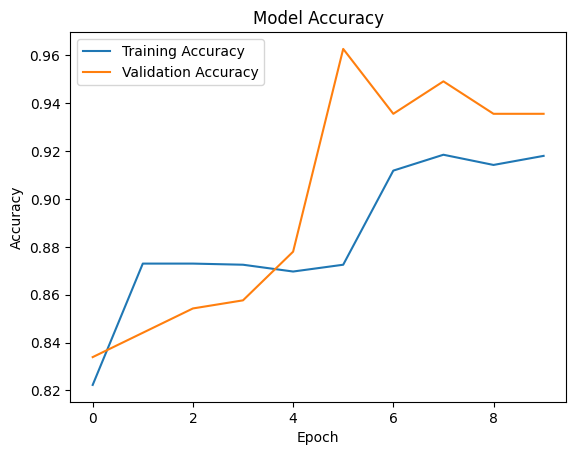

In [13]:

plt.plot(history.history['accuracy'], label='True accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='True Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predicting

In [1]:
# Fake

test_image_path = 'data/IMAGES/FAKE_IMG/biden-to-margot_1.png'
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE) # again, grayscale
test_image = cv2.resize(test_image, (128, 128))
test_image = np.expand_dims(test_image, axis=0) # batch dimension


prediction = model.predict(test_image)

if prediction[0][0] >= 0.5: # the sensitivity can be changed
    print("The audio is predicted as REAL.")
else:
    print("The audio is predicted as FAKE.")


NameError: name 'cv2' is not defined

In [14]:
# Real

test_image_path = 'data/IMAGES/REAL_IMG/biden-original_0.png'
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE) # again, grayscale
test_image = cv2.resize(test_image, (128, 128))
test_image = np.expand_dims(test_image, axis=0) # batch dimension


prediction = model.predict(test_image)

if prediction[0][0] >= 0.5: # the sensitivity can be changed
    print("The audio is predicted as REAL.")
else:
    print("The audio is predicted as FAKE.")


1/1 [==============================] - 0s 28ms/step
The image is predicted as REAL.
